## Requirements

* python-igraph
* set directory in the next cell

In [1]:
datadir = "../Datasets/"

"../Datasets/"

In [2]:
using LightGraphs
using SimpleWeightedGraphs
using DataFrames
using CSV
using PyPlot
using GraphPlot
using LinearAlgebra
using StatsBase
using Random
using CategoricalArrays

In [3]:
ENV["COLUMNS"] = 1000

1000

## US Airport Volume of Passengers

The nodes are represented by the 3-letter airport codes; we also read in the volume of passengers that we use as edge weights. The edges are directed.

We also read node attributes: lat/lon, state, city.

In [4]:
## read edges and build weighted directed graph
D = CSV.read(datadir * "Airports/connections.csv", DataFrame)

,orig_airport,dest_airport,total_passengers
,String,String,Int64
1,SFO,LAX,1442105
2,LAX,SFO,1438639
3,MCO,ATL,1436625
4,ATL,MCO,1424069
5,LAX,JFK,1277731
6,JFK,LAX,1270696
7,FLL,ATL,1199733
8,ATL,FLL,1193529
9,LGA,ATL,1122132


In [5]:
# normalize weights
max_passengers = maximum(D.total_passengers)
D.total_passengers /= max_passengers
extrema(D.total_passengers)

(6.934307834727707e-7, 1.0)

In [6]:
id2name = sort!(unique(union(D.orig_airport, D.dest_airport)))
name2id = Dict(id2name .=> axes(id2name, 1))
g = SimpleWeightedDiGraph(length(id2name))
for row in eachrow(D)
    from = name2id[row.orig_airport]
    to = name2id[row.dest_airport]
    from == to || add_edge!(g, from, to, row.total_passengers)
end
g

{464, 11931} directed simple Int64 graph with Float64 weights

In [7]:
A = CSV.read(datadir * "Airports/airports_loc.csv", DataFrame)
A.id = [name2id[a] for a in A.airport]
@assert A.id == axes(A, 1)
@assert A.airport == id2name
A

,airport,lon,lat,state,city,id
,String,Float64,Float64,String,String,Int64
1,ABE,-75.4408,40.6521,PA,Allentown,1
2,ABI,-99.6819,32.4113,TX,Abilene,2
3,ABQ,-106.609,35.0402,NM,Albuquerque,3
4,ABR,-98.4218,45.4491,SD,Aberdeen,4
5,ABY,-84.1945,31.5355,GA,Albany,5
6,ACT,-97.2305,31.6113,TX,Waco,6
7,ACV,-124.109,40.9781,CA,Eureka,7
8,ACY,-74.5772,39.4576,NJ,Atlantic City,8
9,ADQ,-152.494,57.75,AK,Kodiak,9


In [8]:
connected_components(g)

2-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  454, 455, 456, 457, 458, 460, 461, 462, 463, 464]
 [113, 459]

In [9]:
A[connected_components(g)[end], :]

,airport,lon,lat,state,city,id
,String,Float64,Float64,String,String,Int64
1,DET,-83.0099,42.4092,MI,Detroit,113
2,WVL,-69.6755,44.5332,ME,Augusta,459


In [10]:
maximum(core_number(g))

82

## California subgraph -- we look at several centrality measures 

In [11]:
## Build smaller subgraph for California (you can try other states)
## drop isolated vertices (i.e. without in-state connections)

CA = findall(==("CA"), A.state)
G = induced_subgraph(g, CA)[1]
A_CA = A[CA, :]
NZ = findall(>(0), degree(G))
G = induced_subgraph(G, NZ)[1]
A_CANZ = A_CA[NZ, :]

,airport,lon,lat,state,city,id
,String,Float64,Float64,String,String,Int64
1,ACV,-124.109,40.9781,CA,Eureka,7
2,BFL,-119.057,35.4336,CA,Bakersfield,49
3,CEC,-124.237,41.7802,CA,Crescent City,81
4,CIC,-121.858,39.7954,CA,Chico,86
5,FAT,-119.718,36.7762,CA,Fresno,148
6,IPL,-115.579,32.8342,CA,El Centro,215
7,LAX,-118.408,33.9425,CA,Los Angeles,242
8,MCE,-120.514,37.2847,CA,Merced,269
9,MOD,-120.954,37.6258,CA,Modesto,297


In [12]:
## again the graph is weakly connected except for 2 airports
connected_components(G)

2-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
 [8, 22]

In [13]:
A_CANZ[connected_components(G)[2], :]

,airport,lon,lat,state,city,id
,String,Float64,Float64,String,String,Int64
1,MCE,-120.514,37.2847,CA,Merced,269
2,VIS,-119.393,36.3187,CA,Visalia,455


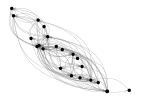

In [14]:
## plot using lat/lon as layout
gplot(G, A_CANZ.lon, -A_CANZ.lat,
      NODESIZE=0.03, nodefillc="black",
      EDGELINEWIDTH=0.2, edgestrokec="gray", arrowlengthfrac=0.05,
      linetype="curve")

In [15]:
dir_degree_centrality(G::SimpleWeightedDiGraph) =
    (vec(sum(G.weights, dims=1)) + vec(sum(G.weights, dims=2))) / (2 * (nv(G)-1))

dir_degree_centrality (generic function with 1 method)

In [16]:
function pagerank_simple(G::SimpleWeightedDiGraph; α=0.85)
    A = G.weights
    B = A ./ sum(A, dims=1)
    B[findall(isnan, B)] .= 1 / nv(G) # handle 0 out-degree nodes
    return (1-α) / nv(G) * ((I - α * B) \ ones(nv(G)))
end

pagerank_simple (generic function with 1 method)

In [17]:
function hub_authority_simple(G::SimpleWeightedDiGraph)
    A = Matrix(G.weights)
    e = eigen(transpose(A) * A)
    λ = e.values[end]
    y = e.vectors[:, end]
    if all(<=(eps()), y)
        y .= -y
    end
    @assert all(>=(-eps()), y)
    x = A * y
    y ./= maximum(y)
    x ./= maximum(x)
    return x, y
end

hub_authority_simple (generic function with 1 method)

In [18]:
function simple_closeness(G::SimpleGraph)
    c = zeros(nv(G))
    for i in 1:nv(G)
        x = gdistances(G, i)
        x .= min.(x, nv(G))
        c .+= x
    end
    return (nv(G) - 1) ./ c
end

simple_closeness (generic function with 1 method)

In [19]:
df = DataFrame("airport" => A_CANZ.airport,
               "degree" => dir_degree_centrality(G),
               "pagerank" => pagerank_simple(G),
               (["authority", "hub"] .=> hub_authority_simple(G))...,
               "between" => 2*betweenness_centrality(SimpleDiGraph(G)),
               "closeness" => simple_closeness(SimpleGraph(SimpleDiGraph(G)))
              )
sort(df, :degree, rev=true)

,airport,degree,pagerank,authority,hub,between,closeness
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,LAX,0.117413,0.214569,1.0,1.0,0.506905,0.318182
2,SFO,0.0896817,0.173044,0.969799,0.906676,0.36229,0.318182
3,SAN,0.0793691,0.123509,0.688636,0.725553,0.0142177,0.291667
4,OAK,0.0465472,0.0727273,0.473682,0.441193,0.0304195,0.287671
5,SJC,0.0419464,0.0665232,0.415783,0.389968,0.0473243,0.3
6,SMF,0.0399795,0.0653626,0.400408,0.377157,0.115465,0.308824
7,SNA,0.0378858,0.059487,0.256703,0.267142,0.00147392,0.283784
8,SBA,0.00649149,0.0167762,0.0775599,0.0780567,0.0119161,0.287671
9,FAT,0.0049718,0.014497,0.0651102,0.0638834,0.0356916,0.3


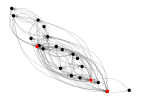

In [20]:
## highlight top-3 airports w.r.t. pagerank
## plot using lat/lon as layout
gplot(G, A_CANZ.lon, -A_CANZ.lat,
      NODESIZE=0.03, nodefillc=ifelse.(ordinalrank(df.pagerank, rev=true) .<= 3, "red", "black"),
      EDGELINEWIDTH=0.2, edgestrokec="gray", arrowlengthfrac=0.05,
      linetype="curve")

In [21]:
## rank-based correlation between measures
corkendall(Matrix(df[:, 2:end]))

6×6 Array{Float64,2}:
 1.0       0.773913  0.986909  0.973913  0.708075  0.811692
 0.773913  1.0       0.759833  0.747826  0.578493  0.589918
 0.986909  0.759833  1.0       0.995643  0.701878  0.815244
 0.973913  0.747826  0.995643  1.0       0.698819  0.820563
 0.708075  0.578493  0.701878  0.698819  1.0       0.854544
 0.811692  0.589918  0.815244  0.820563  0.854544  1.0

In [22]:
coreness = core_number(G)

Mc = maximum(coreness)
mc = minimum(coreness)

color = [x == Mc ? "red" : x <= mc + 1 ? "blue" : "black" for x in coreness]

22-element Array{String,1}:
 "black"
 "black"
 "black"
 "black"
 "red"
 "blue"
 "red"
 "blue"
 "black"
 "blue"
 "red"
 "blue"
 "black"
 "red"
 "red"
 "black"
 "red"
 "red"
 "red"
 "red"
 "black"
 "blue"

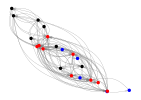

In [23]:
## plot nodes w.r.t. coreness
gplot(G, A_CANZ.lon, -A_CANZ.lat,
      NODESIZE=0.03, nodefillc=color,
      EDGELINEWIDTH=0.2, edgestrokec="gray", arrowlengthfrac=0.05,
      linetype="curve")

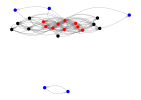

In [24]:
## the above uses the geographical layout, so it is not clear what is going on
## let's use a spring layout
## Different coreness is more clear
Random.seed!(12)
gplot(G,
      NODESIZE=0.03, nodefillc=color,
      EDGELINEWIDTH=0.2, edgestrokec="gray", arrowlengthfrac=0.05,
      linetype="curve")

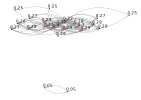

In [25]:
## show closeness centralities, same layout
Random.seed!(12)
gplot(G, nodelabel = round.(df.closeness, digits=2),
      nodelabeldist=8, nodelabelangleoffset=π/4,
      NODESIZE=0.01, nodefillc=color,
      EDGELINEWIDTH=0.2, edgestrokec="gray", arrowlengthfrac=0.05,
      linetype="curve")

In [26]:
## now the 13-core is clearly appearing, and we aso observe a small connected component 
## that was buried in the previous viz.

## vertices in 13-core 
## note that there are less than 14 nodes, this is an interesting remark and
## it is because we consider both in and out-going edges by default for directed graph.
df.airport[coreness .== Mc]

9-element Array{String,1}:
 "FAT"
 "LAX"
 "OAK"
 "SAN"
 "SBA"
 "SFO"
 "SJC"
 "SMF"
 "SNA"

In [27]:
## comparing coreness with other centrality measures
df.coreness = coreness
combine(groupby(df, :coreness, sort=true),
        names(df, Between(:degree, :closeness)) .=> median,
        renamecols=false)

LoadError: UndefVarError: median not defined

In [28]:
## group in 3 categories
df.core_grp = categorical([x <= 2 ? "low" : x == 13 ? "high" : "mid" for x in df.coreness])
levels!(df.core_grp, ["low", "mid", "high"])
df_grp = combine(groupby(df, :core_grp, sort=true),
                 names(df, Between(:degree, :closeness)) .=> mean,
                 renamecols=false)

,core_grp,degree,pagerank,authority,hub,between,closeness
,Cat…,Float64,Float64,Float64,Float64,Float64,Float64
1,low,0.00017483,0.022526,0.00229703,0.00220955,0.0,0.169048
2,mid,0.00174047,0.0101093,0.0203643,0.0204862,0.00392999,0.272069
3,high,0.0515873,0.0896106,0.483076,0.472181,0.125078,0.299553


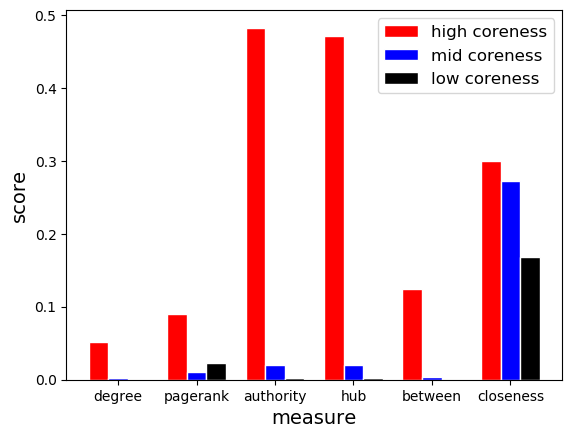

In [29]:
## grouped barplot
bl, bm, bh = Vector.(eachrow(df_grp[:, 2:end]))
barWidth = 0.25
# Set position of bar on X axis
r1 = 1:length(bh)
r2 = r1 .+ barWidth
r3 = r2 .+ barWidth
 # Make the plot
bar(r1, bh, color="red", width=barWidth, edgecolor="white", label="high coreness")
bar(r2, bm, color="blue", width=barWidth, edgecolor="white", label="mid coreness")
bar(r3, bl, color="black", width=barWidth, edgecolor="white", label="low coreness")
 
# Add xticks on the middle of the group bars
xlabel("measure",fontsize=14)
xticks(r2, names(df_grp, Not(1)), fontsize=10)
ylabel("score",fontsize=14) 
# Create legend & Show graphic
legend(fontsize=12);

### delta-centrality example

In [30]:
## Delta-centrality with a simple pandemic spread model
function spread(A::AbstractMatrix, α=0.1)
    One = ones(size(A, 1))
    X = I-α*transpose(A)
    return transpose(One) * (X \ One) / size(A, 1)
end

function spread_delta_centrality(g::SimpleDiGraph, α=0.1)
    A = Matrix(adjacency_matrix(g))
    dc = Float64[]
    spr = spread(A, α)
    for i in 1:nv(g)
        A′ = copy(A)
        A′[i, :] .= 0
        A′[:, i] .= 0
        push!(dc, (spr-spread(A′, α))/spr)
    end
    return dc
end

spread_delta_centrality (generic function with 2 methods)

In [31]:
df.delta = spread_delta_centrality(SimpleDiGraph(G))
df2 = sort(df, :delta, rev=true)

,airport,degree,pagerank,authority,hub,between,closeness,coreness,core_grp,delta
,String,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Cat…,Float64
1,SFO,0.0896817,0.173044,0.969799,0.906676,0.36229,0.318182,13,high,0.578144
2,LAX,0.117413,0.214569,1.0,1.0,0.506905,0.318182,13,high,0.576599
3,SMF,0.0399795,0.0653626,0.400408,0.377157,0.115465,0.308824,13,high,0.511831
4,SJC,0.0419464,0.0665232,0.415783,0.389968,0.0473243,0.3,13,high,0.467405
5,SAN,0.0793691,0.123509,0.688636,0.725553,0.0142177,0.291667,13,high,0.432719
6,FAT,0.0049718,0.014497,0.0651102,0.0638834,0.0356916,0.3,13,high,0.393341
7,OAK,0.0465472,0.0727273,0.473682,0.441193,0.0304195,0.287671,13,high,0.381859
8,SBA,0.00649149,0.0167762,0.0775599,0.0780567,0.0119161,0.287671,13,high,0.376567
9,SNA,0.0378858,0.059487,0.256703,0.267142,0.00147392,0.283784,13,high,0.350028


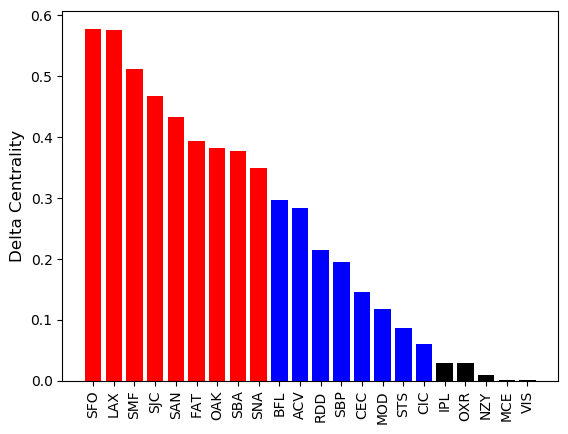

In [32]:
heights = df2.delta
bars = df2.airport
y_pos = axes(bars, 1)
bar(y_pos, heights, color=recode(get.(df2.core_grp), "high" => "red", "mid" => "blue", "low" => "black"))
# Rotation of the bars names
ylabel("Delta Centrality",fontsize=12)
xticks(y_pos, bars, rotation=90)
yticks();

## Group centrality, centralization

Back to US graph, 
- which states have highest delta centralities w.r.t. efficiency?
- what about centralization for each state subgraph?

In [33]:
## group delta centrality
function efficiency(g::SimpleDiGraph)
    n = nv(g)
    s = 0
    for i in 1:n
        v = gdistances(g, i)
        s += sum([1/x for x in v if 0 < x < n])
    end
    return s/(n*(n-1))
end

efficiency (generic function with 1 method)

In [34]:
sg = SimpleDiGraph(g)
states = unique(A.state)
eff_us = efficiency(sg)
dc = Float64[]
for s in states
    v = findall(==(s), A.state)
    csg = copy(sg)
    for i in 1:nv(csg), j in v
        rem_edge!(csg, i, j)
        rem_edge!(csg, j, i)
    end
    push!(dc, (eff_us - efficiency(csg)) / eff_us)
end
DC = DataFrame(state=states, delta_centrality=dc)
sort!(DC, :delta_centrality, rev=true)
first(DC, 3)

,state,delta_centrality
,String,Float64
1,TX,0.159289
2,CA,0.134366
3,FL,0.113134


In [35]:
last(DC, 3)

,state,delta_centrality
,String,Float64
1,DE,0.00840951
2,RI,0.00554134
3,NH,0.00534307


In [36]:
## group centralization (using PageRank) -- by state
states = unique(A.state)
pr = Float64[]
st = String[]
for s in states
    v = findall(==(s), A.state)
    if length(v) > 5 ## look at states with more than 5 airports only
        G = induced_subgraph(g, v)[1]
        p = pagerank_simple(G)
        push!(pr, maximum(p) - mean(p))
        push!(st, s)
    end
end

DC = DataFrame("State" => st, "Pagerank Centralization" => pr)
sort!(DC, 2, rev=true)

,State,Pagerank Centralization
,String,Float64
1,MI,0.372879
2,GA,0.360744
3,NC,0.357549
4,PA,0.350522
5,IL,0.344592
6,AZ,0.328808
7,UT,0.32475
8,MN,0.318566
9,OR,0.318524


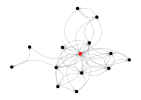

In [37]:
Random.seed!(12)
v = findall(==("MI"), A.state)
G = induced_subgraph(g, v)[1]
NZ = findall(>(0), degree(G))
G = induced_subgraph(G, NZ)[1]
gplot(G,
      NODESIZE=0.03, nodefillc=[x == "DET" ? "red" : "black" for x in A.airport[v]],
      EDGELINEWIDTH=0.2, edgestrokec="gray", arrowlengthfrac=0.05,
      linetype="curve")

In [38]:
## state with one big hub city: Detroit
A.city[v[NZ]]

14-element Array{String,1}:
 "Alpena"
 "Kalamazoo"
 "Battle Creek"
 "Detroit"
 "Escanaba"
 "Flint"
 "Grand Rapids"
 "Iron Mountain"
 "Lansing"
 "Saginaw"
 "Muskegon"
 "Marquette"
 "Traverse City"
 "Detroit"

In [39]:
## lowest ones

last(DC, 3)

,State,Pagerank Centralization
,String,Float64
1,NE,0.0765766
2,AR,0.0666119
3,ND,0.0611964


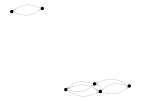

In [40]:
Random.seed!(3)
v = findall(==("ND"), A.state)
G = induced_subgraph(g, v)[1]
NZ = findall(>(0), degree(G))
G = induced_subgraph(G, NZ)[1]
gplot(G,
      NODESIZE=0.03, nodefillc="black",
      EDGELINEWIDTH=0.2, edgestrokec="gray", arrowlengthfrac=0.05,
      linetype="curve")

In [41]:
# no big city, two components
A.city[v]

8-element Array{String,1}:
 "Bismarck"
 "Dickinson"
 "Fargo"
 "Grand Forks"
 "Williston"
 "Jamestown"
 "Minot"
 "Minot"

In [42]:
# what about California
last(DC, 15)

,State,Pagerank Centralization
,String,Float64
1,SC,0.198217
2,MT,0.184402
3,CA,0.169906
4,IA,0.155924
5,TX,0.142657
6,LA,0.14023
7,FL,0.134574
8,VA,0.132685
9,WY,0.114106
